In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, ColumnTransformer, TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from utils import train_and_plot_learning_curve
from sklearn.svm import SVR

In [2]:
df = pd.read_csv('../data/features/train.csv', sep=';', index_col=0)

df['foundation_type'] = df['foundation_type'].astype('category')
df['concrete_code'] = df['concrete_code'].astype('category')
df['load_code'] = df['load_code'].astype('category')
df['wind_code'] = df['wind_code'].astype('category')
df['seismic_code'] = df['seismic_code'].astype('category')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1654 entries, 0 to 1653
Data columns (total 78 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   foundation_type             1654 non-null   category
 1   concrete_code               1654 non-null   category
 2   load_code                   1654 non-null   category
 3   wind_code                   1654 non-null   category
 4   seismic_code                1654 non-null   category
 5   floor_number                1654 non-null   int64   
 6   total_height                1654 non-null   float64 
 7   height                      1654 non-null   float64 
 8   foundation_height           1654 non-null   float64 
 9   double_height               1654 non-null   float64 
 10  triple_height               1654 non-null   float64 
 11  support_column              1654 non-null   int64   
 12  unsupported_column          1654 non-null   int64   
 13  walls_number      

## Preparando los datos

In [4]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("cat", cat_pipeline, make_column_selector(dtype_include='category')),
    ],
    remainder=default_num_pipeline) 

# Datos de entrada

In [5]:
df = df.drop(['center_x', 'center_y', 'cdm_x', 'cdm_y', 'cdr_x', 'cdr_y'], axis=1)

In [6]:
X = df.drop("reinf_steel_ratio", axis=1)
y = df["reinf_steel_ratio"].copy()

In [7]:
len(X.columns)

71

In [8]:
X.columns

Index(['foundation_type', 'concrete_code', 'load_code', 'wind_code',
       'seismic_code', 'floor_number', 'total_height', 'height',
       'foundation_height', 'double_height', 'triple_height', 'support_column',
       'unsupported_column', 'walls_number', 'retaining_walls_number',
       'support_area', 'walls_area', 'retaining_walls_area', 'LL', 'DL',
       'LL_max', 'DL_max', 'wind_load_x', 'wind_load_y', 'seismic_acc',
       'slab_total_area', 'flat_slab_area', 'waffle_slab_area', 'depth',
       'drop_panel_area', 'domes_area', 'domes_number', 'inter_axis_distance',
       'shape_factor', 'x_length', 'y_length', 'concrete_m3_ratio',
       'slab_area_mean', 'height_mean', 'double_height_ratio',
       'triple_height_ratio', 'slenderness', 'column_area', 'swall_num',
       'swall_area', 'swall_area_mean', 'col_area_mean', 'rwalls_area_mean',
       'swall_area_mean_m2', 'col_area_mean_m2', 'rwalls_area_mean_m2',
       'swall_area_ratio', 'col_area_ratio', 'rwals_area_ratio', 

# SBR RBF

In [9]:
MAX_ITER = 10_000_000

In [10]:
svr_rbf = make_pipeline(preprocessing, SVR(kernel="rbf"))
svr_rbf = TransformedTargetRegressor(svr_rbf, transformer=StandardScaler())

In [11]:
%%time
svr_rbf_mapes = cross_val_score(svr_rbf, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)
pd.Series(svr_rbf_mapes).describe()

CPU times: user 1.25 s, sys: 22.3 ms, total: 1.27 s
Wall time: 1.27 s


count    10.000000
mean      0.084138
std       0.012673
min       0.069853
25%       0.073651
50%       0.080347
75%       0.093130
max       0.104912
dtype: float64

In [12]:
svr_rbf_mapes

array([0.10491217, 0.07346445, 0.06985253, 0.08978565, 0.08380665,
       0.07308949, 0.0742126 , 0.09424516, 0.07688671, 0.10112511])

CPU times: user 1.13 s, sys: 1.53 s, total: 2.66 s
Wall time: 3.46 s


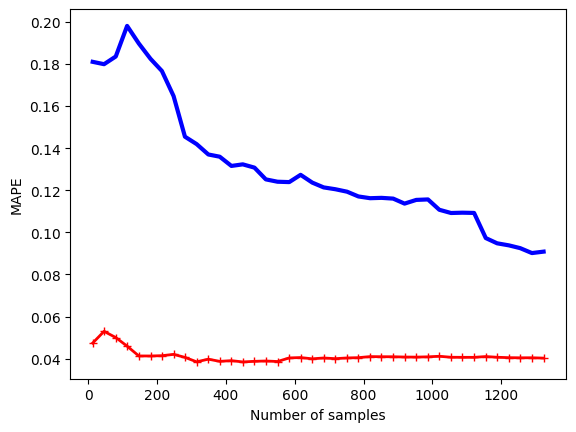

In [13]:
%%time
fig, ax = train_and_plot_learning_curve(svr_rbf, X, y)
fig.savefig('../reports/figures/train/default_svr_rbf_cv.pdf', bbox_inches='tight')

# Grid Search

In [14]:
%%time
epsilon_range = [0.03, 0.04, 0.05]
C_range = [5, 6, 7]
gamma_range = [0.006, 0.007, 0.008]
param_grid = {
    'regressor__svr__epsilon': epsilon_range, 
    'regressor__svr__gamma': gamma_range, 
    'regressor__svr__C': C_range
}

svr_rbf_grid = GridSearchCV(svr_rbf, param_grid=param_grid, cv=10, n_jobs=-1, 
                           scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))
svr_rbf_grid.fit(X, y)

CPU times: user 1.09 s, sys: 177 ms, total: 1.27 s
Wall time: 7.58 s


GridSearchCV(cv=10,
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('columntransformer',
                                                                             ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                                                          SimpleImputer(strategy='median')),
                                                                                                                         ('standardscaler',
                                                                                                                          StandardScaler())]),
                                                                                               transformers=[('cat',
                                                                                                              Pipeline(steps=[('simpleimputer',
                                                                                                                               SimpleImputer(strategy='most_frequent')),
                                                                                                                              ('onehotencoder',
                                                                                                                               On...))]),
                                                                                                              <sklearn.compose._column_transformer.make_column_selector object at 0x7f2e36c6f5e0>)])),
                                                                            ('svr',
                                                                             SVR())]),
                                                  transformer=StandardScaler()),
             n_jobs=-1,
             param_grid={'regressor__svr__C': [5, 6, 7],
                         'regressor__svr__epsilon': [0.03, 0.04, 0.05],
                         'regressor__svr__gamma': [0.006, 0.007, 0.008]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [15]:
svr_rbf_grid.best_params_

{'regressor__svr__C': 7,
 'regressor__svr__epsilon': 0.03,
 'regressor__svr__gamma': 0.008}

# Best Model

In [16]:
best_params = {key.split('__')[-1]: value for key, value in svr_rbf_grid.best_params_.items()}
best_params

{'C': 7, 'epsilon': 0.03, 'gamma': 0.008}

In [17]:
%%time
svr_rbf = make_pipeline(preprocessing, SVR(kernel="rbf", **best_params))
svr_rbf = TransformedTargetRegressor(svr_rbf, transformer=StandardScaler())
svr_rbf_mapes = cross_val_score(svr_rbf, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)
pd.Series(svr_rbf_mapes).describe()

CPU times: user 2.26 s, sys: 18.1 ms, total: 2.28 s
Wall time: 2.28 s


count    10.000000
mean      0.078442
std       0.013070
min       0.059589
25%       0.068757
50%       0.076900
75%       0.085968
max       0.102720
dtype: float64

CPU times: user 985 ms, sys: 1.48 s, total: 2.46 s
Wall time: 4.02 s


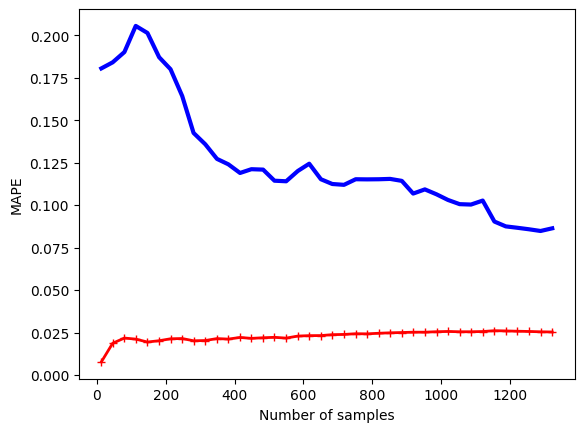

In [22]:
%%time
fig, ax = train_and_plot_learning_curve(svr_rbf, X, y)
fig.savefig('../reports/figures/train/best_svr_rbf_cv.pdf', bbox_inches='tight')